In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
# параметры распределений
mu0x, sigma0x = -2., 1.
mu0y, sigma0y = -1.5, 1.5
mu1x, sigma1x = 3., 2.
mu1y, sigma1y = 2.5, 2.5

In [64]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [65]:
d0 = torch.distributions.Normal(torch.tensor([mu0x, mu0y]), torch.tensor([sigma0x, sigma0y]))
d1 = torch.distributions.Normal(torch.tensor([mu1x, mu1y]), torch.tensor([sigma1x, sigma1y]))

In [66]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.Adam(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.1865, -0.2385]), tensor(0.2909)]


In [67]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 1.306133
Ошибка после 1 итераций: 0.389385
Ошибка после 2 итераций: 0.219123
Ошибка после 3 итераций: 0.159925
Ошибка после 4 итераций: 0.130636
Ошибка после 5 итераций: 0.112984
Ошибка после 6 итераций: 0.101718
Ошибка после 7 итераций: 0.093261
Ошибка после 8 итераций: 0.088425
Ошибка после 9 итераций: 0.083278
Ошибка после 10 итераций: 0.079737
Ошибка после 11 итераций: 0.077301
Ошибка после 12 итераций: 0.076674
Ошибка после 13 итераций: 0.074809
Ошибка после 14 итераций: 0.073348
Ошибка после 15 итераций: 0.070997
Ошибка после 16 итераций: 0.073104
Ошибка после 17 итераций: 0.073439
Ошибка после 18 итераций: 0.071868
Ошибка после 19 итераций: 0.072587


In [76]:
x_scale = y_scale = np.linspace(-10, 10, 500)

d0x_pdf = stats.norm.pdf(x_scale, mu0x, sigma0x).reshape(-1, 1)
d0y_pdf = stats.norm.pdf(x_scale, mu0y, sigma0y).reshape(1, -1)
d1x_pdf = stats.norm.pdf(x_scale, mu1x, sigma1x).reshape(-1, 1)
d1y_pdf = stats.norm.pdf(x_scale, mu1y, sigma1y).reshape(1, -1)

x_test, y_test = sample(d0, d1, 100)
x_test = x_test.numpy()
y_test = y_test.numpy().reshape(-1)

d0_pdf = d0x_pdf @ d0y_pdf
d1_pdf = d1x_pdf @ d1y_pdf

x_set = np.tile(x_scale, y_scale.shape[0])
y_set = np.repeat(y_scale, x_scale.shape[0])
d_set = np.c_[x_set, y_set]

input_tensor = torch.tensor(d_set, dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(input_tensor)).numpy()
fl = dist.flatten()

border = d_set[(fl >= 0.49) & (fl <= 0.51)] # линия вероятности 0,5

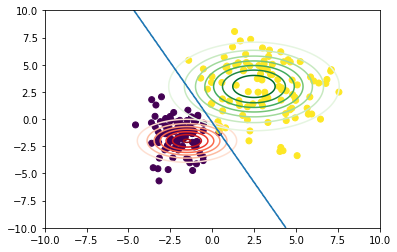

In [77]:
plt.contour(x_scale, y_scale, d0_pdf, cmap='Reds')
plt.contour(x_scale, y_scale, d1_pdf, cmap='Greens')
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.plot(border[:, 0], border[:, 1]) # линия вероятности 0,5
plt.show()